In [2]:
from utils import *

In [3]:
gt = pd.read_excel('/home/tobamo/analize/project-tobamo/analysis/data/domain_sci_input/ground_truth_20250630.xlsx')
gt.columns = gt.columns.str.strip()
pr = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/predictions/contig_predictions.csv')
df = pd.merge(gt, pr, on='contig_name', how='inner')

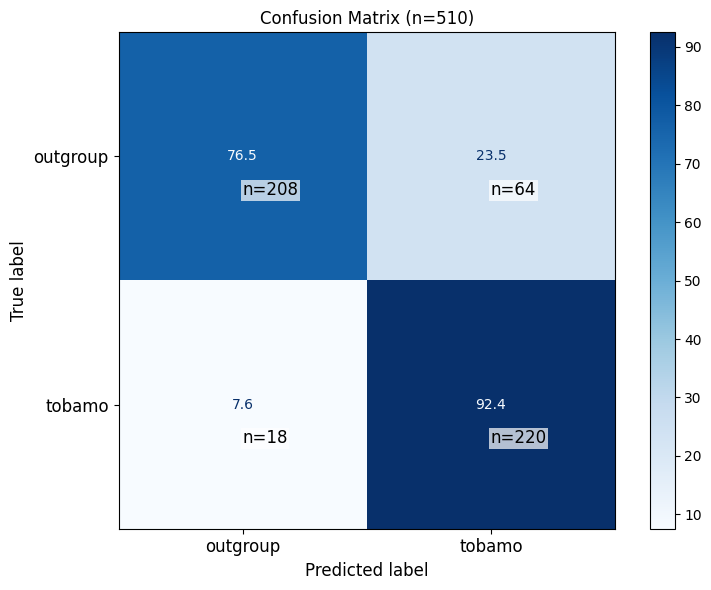

In [5]:
# Generate the confusion matrix
cm = confusion_matrix(df['ground_truth'], df['predicted_class'])

# Normalize the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Display the confusion matrix with percentages - use custom labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage,
    display_labels=['outgroup', 'tobamo']  # Custom labels instead of 0,1
)
disp.plot(cmap=plt.cm.Blues, values_format=".1f", ax=ax)

# Set fontsize for tick labels and axis labels
ax.tick_params(labelsize=12)
ax.set_xlabel('Predicted label', fontsize=12)
ax.set_ylabel('True label', fontsize=12)

# Add text annotations for the actual counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Position the raw count in the top-left corner of each cell
        ax.text(j, i+0.1, f"n={cm[i, j]}", 
                va='top', ha='left',
                fontsize=12, 
                color='black', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Set title and adjust layout
plt.title(f"Confusion Matrix (n={len(df)})")
plt.tight_layout()
plt.show()

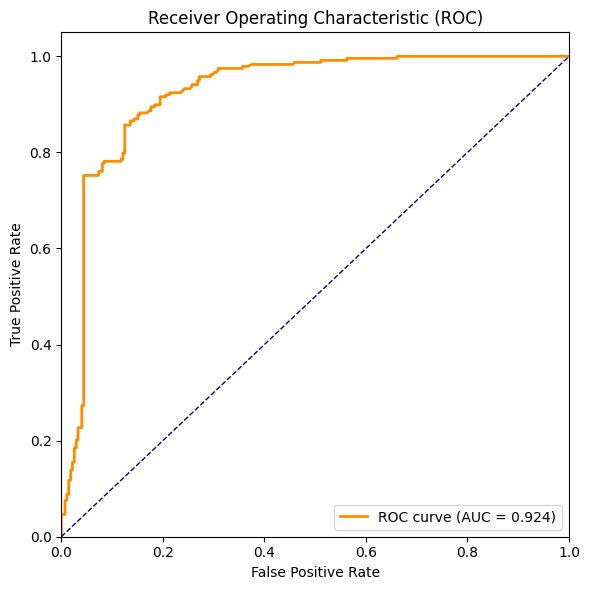

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(df['ground_truth'], df['prob_1'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

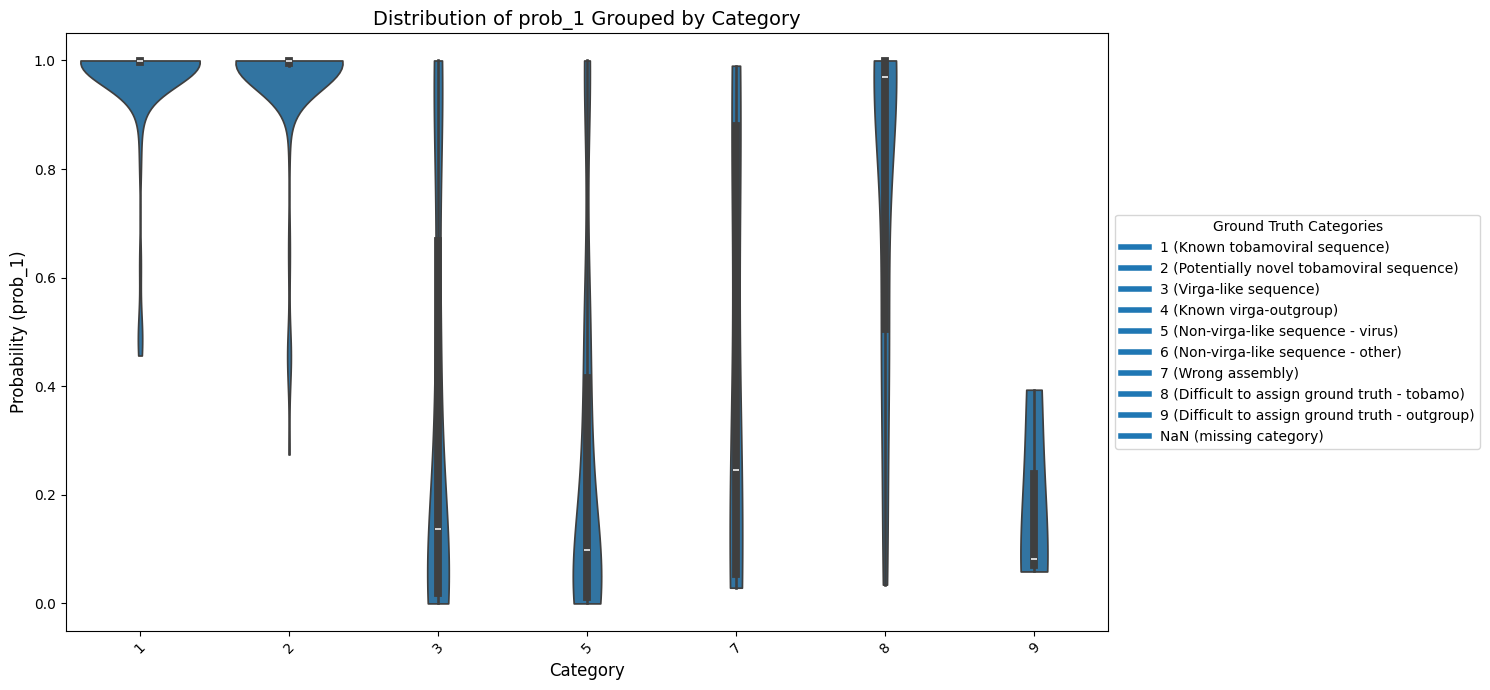

In [6]:
# Group by 'ground_truth' and visualize the distribution of 'prob_1'
plt.figure(figsize=(15, 7))

# Sort ground_truth labels alphabetically
df_filtered = df.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())

# Create a boxplot for prob_1 grouped by ground_truth with sorted labels
sns.violinplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, cut=0) # cut=0 avoids showing tails beyond the data range

# Add labels and title
plt.xlabel('Category', fontsize=12)
plt.ylabel('Probability (prob_1)', fontsize=12)
plt.title('Distribution of prob_1 Grouped by Category', fontsize=14)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Add a custom legend
legend_labels = [
    "1 (Known tobamoviral sequence)",
    "2 (Potentially novel tobamoviral sequence)",
    "3 (Virga-like sequence)",
    "4 (Known virga-outgroup)",
    "5 (Non-virga-like sequence - virus)",
    "6 (Non-virga-like sequence - other)",
    "7 (Wrong assembly)",
    "8 (Difficult to assign ground truth - tobamo)",
    "9 (Difficult to assign ground truth - outgroup)",
    "NaN (missing category)"
]

plt.legend(
    handles=[plt.Line2D([0], [0], lw=4, label=label) for label in legend_labels],
    loc='center left',  # Position the legend to the left of the bounding box
    bbox_to_anchor=(1, 0.5),  # Place the legend outside the plot area to the right
    title="Ground Truth Categories",
    fontsize=10
)
# Show the plot
plt.tight_layout()
plt.show()

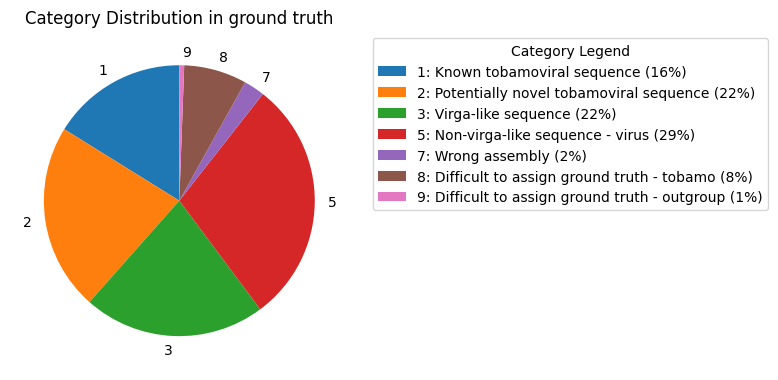

In [7]:
import matplotlib.pyplot as plt

# Prepare value counts (including NaN as a category)
category_counts = gt['category'].value_counts(dropna=False).sort_index()
total = category_counts.sum()

# Pie plot with only category numbers as labels (no percentages)
plt.figure(figsize=(8, 8))
labels = [str(int(cat)) if not pd.isna(cat) else "NaN" for cat in category_counts.index]

# Get colors from the pie chart
wedges, texts = plt.pie(
    category_counts,
    labels=labels,
    startangle=90,
    labeldistance=1.1
)
pie_colors = [w.get_facecolor() for w in wedges]  # Save the color palette

# Define the mapping dictionary
category_map = {
    1: "Known tobamoviral sequence",
    2: "Potentially novel tobamoviral sequence",
    3: "Virga-like sequence",
    4: "Known virga-outgroup",
    5: "Non-virga-like sequence - virus",
    6: "Non-virga-like sequence - other",
    7: "Wrong assembly",
    8: "Difficult to assign ground truth - tobamo",
    9: "Difficult to assign ground truth - outgroup",
    float('nan'): "NaN (missing category)"
}

# Build legend labels with percentages (rounded to integer)
legend_labels = []
for cat in category_counts.index:
    count = category_counts[cat]
    percent = round(100 * count / total)
    if pd.isna(cat):
        legend_labels.append(f"NaN: missing category ({percent}%)")
    else:
        legend_labels.append(f"{int(cat)}: {category_map.get(int(cat), 'Unknown')} ({percent}%)")

plt.legend(wedges, legend_labels, title="Category Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Category Distribution in ground truth')
plt.tight_layout()
plt.show()

# pie_colors now contains the color palette for each category in order of category_counts.index

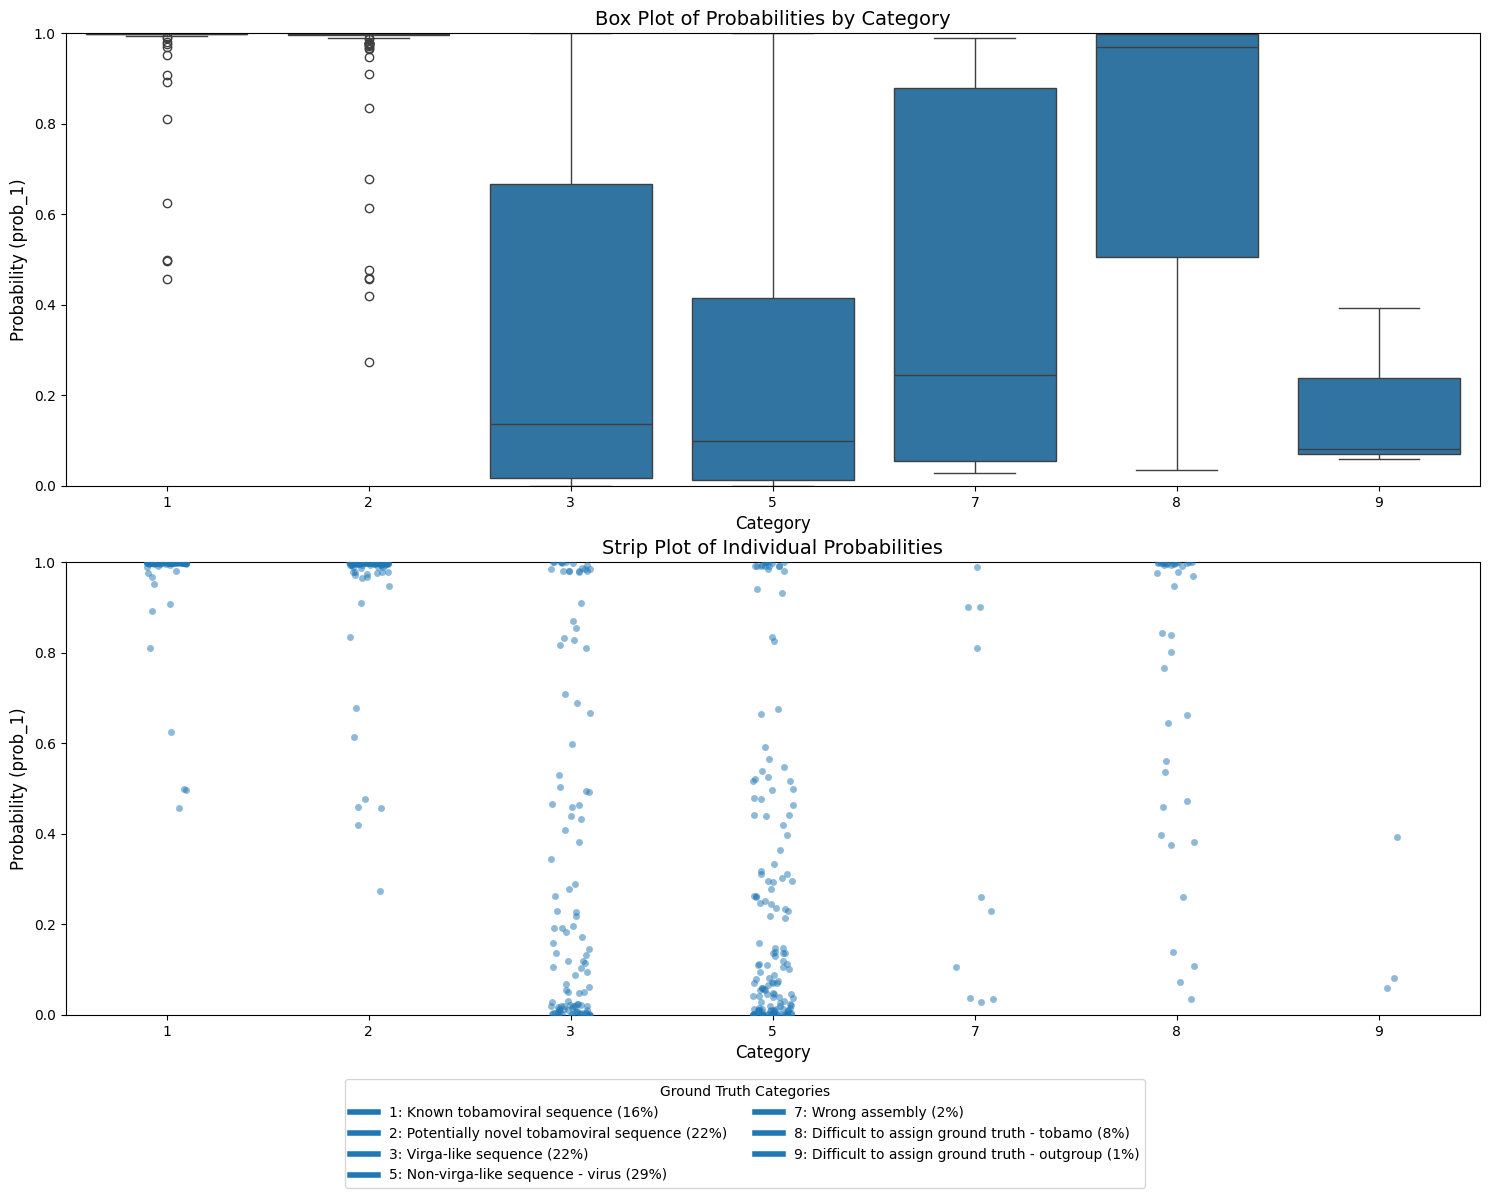

In [8]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Box plot - Shows median, quartiles, and outliers clearly
sns.boxplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, ax=axes[0])
axes[0].set_title('Box Plot of Probabilities by Category', fontsize=14)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Probability (prob_1)', fontsize=12)
axes[0].set_ylim(0, 1)  # Enforce proper probability range
axes[0].tick_params(axis='x')  # Rotate x-axis labels

# 2. Strip plot - Shows individual data points
sns.stripplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
              jitter=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Strip Plot of Individual Probabilities', fontsize=14)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Probability (prob_1)', fontsize=12)
axes[1].set_ylim(0, 1)  # Enforce proper probability range
axes[1].tick_params(axis='x')  # Rotate x-axis labels

# Add a legend for the figure with the category descriptions
fig.legend(
    handles=[plt.Line2D([0], [0], lw=4, label=label) for label in legend_labels],
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories",
    fontsize=10,
    ncol=2
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend at the bottom
plt.show()